In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
y_test = np.load("y_test.npy")

In [3]:
# 550 data with 300 features
print(x_train.shape)

(550, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
def cross_validation(x_train, y_train, k=5):
    indices = np.arange(len(x_train))
    
    # use random seed to mak each samele at anytime is different.
    np.random.seed()
    np.random.shuffle(indices)
    folds = np.array_split(indices, k)
    folds = np.array(folds)

    k_fold = []
    for i in range(k):
        train_fold = np.delete(np.arange(k), i)
        k_fold.append([np.concatenate((folds[train_fold]), axis=None), folds[i]])
    return k_fold

In [6]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 55 # The number of data in each validation fold should equal to training data divieded by K

In [7]:
# test the cross validation with small data
X = np.arange(20)
_kfold_data = cross_validation(X, X, k=5)
for i, (traing_idx, validation_idx) in enumerate(_kfold_data):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, traing_idx, validation_idx))

Split: 1, Training index: [ 9 19 15  5 10 14 16  3 13 17  6  8  2 12  1  7], Validation index: [18  4  0 11]
Split: 2, Training index: [18  4  0 11 10 14 16  3 13 17  6  8  2 12  1  7], Validation index: [ 9 19 15  5]
Split: 3, Training index: [18  4  0 11  9 19 15  5 13 17  6  8  2 12  1  7], Validation index: [10 14 16  3]
Split: 4, Training index: [18  4  0 11  9 19 15  5 10 14 16  3  2 12  1  7], Validation index: [13 17  6  8]
Split: 5, Training index: [18  4  0 11  9 19 15  5 10 14 16  3 13 17  6  8], Validation index: [ 2 12  1  7]


## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [8]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [9]:
# use cross validation before training
kfold_data = cross_validation(x_train, y_train, k=5)

C = [0.5, 1, 3, 5, 7, 10, 20, 50]
gamma = [0.0005, 0.001, 0.002, 0.003, 0.004, 0.005]

average_scores = np.zeros((len(C), len(gamma)))
best_score = 0
best_model = None
best_hyperparameter = [0, 0]

# train SVC by grid search of C and gamma
for i in range(len(C)):
    for j in range(len(gamma)):
        score = 0

        # use cross validation data to train and evaluate the model performance
        for traing_idx, validation_idx in kfold_data:
            clf = SVC(C=C[i], kernel='rbf', gamma=gamma[j])
            clf.fit(x_train[traing_idx], y_train[traing_idx])
            score += clf.score(x_train[validation_idx], y_train[validation_idx])

        average_scores[i][j] = score / len(kfold_data)
        
        # record the best model
        if average_scores[i][j] > best_score:
            best_score = average_scores[i][j]
            best_model = clf
            best_hyperparameter = [C[i], gamma[j]]

In [10]:
print(f'Best C={best_hyperparameter[0]}, gamma={best_hyperparameter[1]}')
print("score:", best_score)

Best C=5, gamma=0.001
score: 0.8836363636363636


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

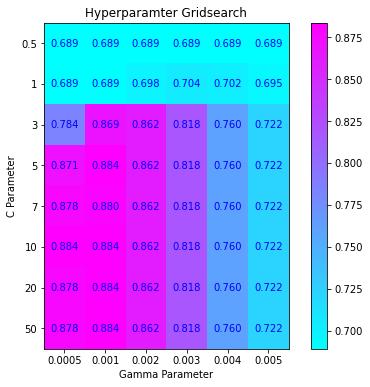

In [11]:
# Plot the grid search results of my SVM
len_C = len(C)
len_gamma = len(gamma)

plt.figure(figsize=(8, 6))
plt.imshow(average_scores, cmap='cool', interpolation='nearest')
plt.xticks(np.arange(len_gamma), gamma)
plt.yticks(np.arange(len_C), C)
plt.xlabel("Gamma Parameter")
plt.ylabel("C Parameter")
plt.title("Hyperparamter Gridsearch")
plt.colorbar()

# add validation score to the heatmap
for i in range(len_C):
    for j in range(len_gamma):
        plt.text(j, i, f'{average_scores[i][j]:.3f}', ha='center', va='center', color='b')

plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [12]:
# By several experiments, I find that use C=5 and gamma=0.002 can get the best result.
best_model = SVC(C=5, kernel='rbf', gamma=0.002)
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

Accuracy score:  0.9166666666666666
